In [11]:
import torch
import torch.nn as nn
import torchvision

from torchvision import transforms

In [12]:
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

In [13]:
image_path = "../data"

In [14]:
def get_smile(attr):
    return attr[18]

In [28]:
transform_train = transforms.Compose(
    [
        transforms.RandomCrop([178, 178]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.1),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [29]:
transform_val = transforms.Compose(
    [
        transforms.CenterCrop([178, 178]),
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [30]:
from torch.utils.data import DataLoader

In [31]:
celeba_train_dataset = torchvision.datasets.CelebA(
    image_path,
    split="train",
    target_type="attr",
    download=False,
    transform=transform_train,
    target_transform=get_smile,
)

celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path,
    split="valid",
    target_type="attr",
    download=False,
    transform=transform_val,
    target_transform=get_smile,
)

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path,
    split="test",
    target_type="attr",
    download=False,
    transform=transform_val,
    target_transform=get_smile,
)

In [32]:
from torch.utils.data import Subset

celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(10000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))

In [33]:
batch_size = 32
torch.manual_seed(1)

train_dl = DataLoader(
    celeba_train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

valid_dl = DataLoader(
    celeba_valid_dataset,
    batch_size=batch_size,
    shuffle=False,
)

test_dl = DataLoader(
    celeba_test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [34]:
model = nn.Sequential()

# First block
model.add_module(
    "conv1_1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
)
model.add_module("bn1_1", nn.BatchNorm2d(32))
model.add_module("relu1_1", nn.ReLU())
model.add_module(
    "conv1_2", nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
)
model.add_module("bn1_2", nn.BatchNorm2d(32))
model.add_module("relu1_2", nn.ReLU())
model.add_module("pool1", nn.MaxPool2d(kernel_size=2))
model.add_module("dropout1", nn.Dropout(p=0.3))

# Second block
model.add_module(
    "conv2_1", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
)
model.add_module("bn2_1", nn.BatchNorm2d(64))
model.add_module("relu2_1", nn.ReLU())
model.add_module(
    "conv2_2", nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
)
model.add_module("bn2_2", nn.BatchNorm2d(64))
model.add_module("relu2_2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(kernel_size=2))
model.add_module("dropout2", nn.Dropout(p=0.3))

# Third block
model.add_module(
    "conv3_1", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
)
model.add_module("bn3_1", nn.BatchNorm2d(128))
model.add_module("relu3_1", nn.ReLU())
model.add_module(
    "conv3_2", nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
)
model.add_module("bn3_2", nn.BatchNorm2d(128))
model.add_module("relu3_2", nn.ReLU())
model.add_module("pool3", nn.MaxPool2d(kernel_size=2))
model.add_module("dropout3", nn.Dropout(p=0.3))

# Fourth block
model.add_module(
    "conv4_1", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
)
model.add_module("bn4_1", nn.BatchNorm2d(256))
model.add_module("relu4_1", nn.ReLU())
model.add_module(
    "conv4_2", nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
)
model.add_module("bn4_2", nn.BatchNorm2d(256))
model.add_module("relu4_2", nn.ReLU())
model.add_module("pool4", nn.AvgPool2d(kernel_size=8))

# Fully connected layers
model.add_module("flatten", nn.Flatten())
model.add_module("fc1", nn.Linear(256, 128))
model.add_module("relu5", nn.ReLU())
model.add_module("dropout4", nn.Dropout(p=0.5))
model.add_module("fc2", nn.Linear(128, 1))
model.add_module("sigmoid", nn.Sigmoid())

In [35]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()

            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(
            f"Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}"
        )

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [37]:
torch.manual_seed(1)
num_epochs = 3
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.6732 val_accuracy: 0.7220
Epoch 2 accuracy: 0.7282 val_accuracy: 0.7570
Epoch 3 accuracy: 0.7603 val_accuracy: 0.8030


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], "-o", label="Train loss")
ax.plot(x_arr, hist[1], "--<", label="Validation loss")
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], "-o", label="Train acc.")
ax.plot(x_arr, hist[3], "--<", label="Validation acc.")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)

plt.show()

In [38]:
accuracy_test = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        is_correct = ((pred >= 0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum()

accuracy_test /= len(test_dl.dataset)
print(f"Test accuracy: {accuracy_test:.4f}")

Test accuracy: 0.7813


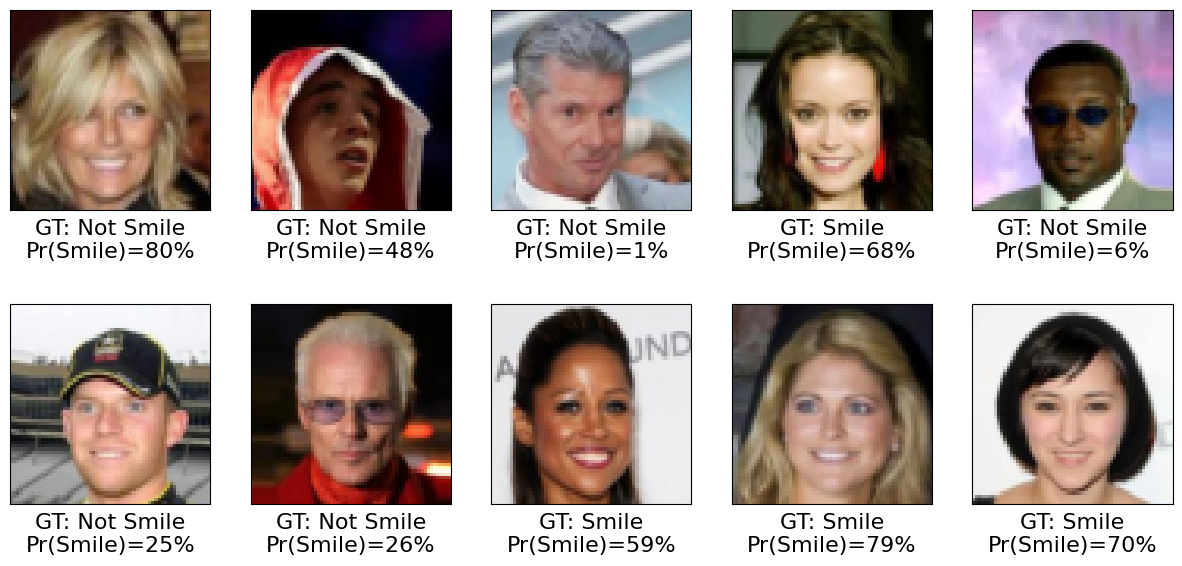

In [41]:
import matplotlib.pyplot as plt

pred = model(x_batch)[:, 0] * 100
fig = plt.figure(figsize=(15, 7))

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
x_orig = x_batch * std[None, :, None, None] + mean[None, :, None, None]

for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j - 10 + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(x_orig[j].permute(1, 2, 0).clamp(0, 1))

    if y_batch[j] == 1:
        label = "Smile"
    else:
        label = "Not Smile"

    ax.text(
        0.5,
        -0.15,
        f"GT: {label:s}\nPr(Smile)={pred[j]:.0f}%",
        size=16,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
    )

plt.show()

In [42]:
import numpy as np

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

sorted_indices = np.argsort(all_preds)[::-1]
sorted_labels = all_labels[sorted_indices]

n_pos = np.sum(all_labels == 1)
n_neg = len(all_labels) - n_pos
tpr = np.cumsum(sorted_labels) / n_pos
fpr = np.cumsum(1 - sorted_labels) / n_neg

auc_score = np.trapz(y=tpr, x=fpr)
print(f"AUC-ROC Score: {auc_score:.4f}")

AUC-ROC Score: 0.8652


/var/folders/cp/y605gsj11zd0js5ky7y01ssr0000gn/T/ipykernel_27162/2360650210.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(y=tpr, x=fpr)
